# CS236605:   Deep Learning
# Tutorial 7: Autoencoders and GANs 



## Introduction

In this tutorial, we will cover:

* Denoising Autoencoders
* DGASNs

## Denoising Autoencoders

In [7]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

from torch.nn import functional as F

**Create the datasets**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

https://www.cs.toronto.edu/~kriz/cifar.html

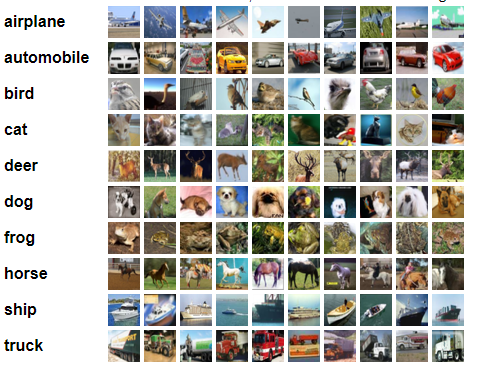

In [3]:
transform=transforms.Compose([transforms.ToTensor()])

cifar10_train = datasets.CIFAR10('./data.cifar10', train=True, download=True, transform=transform)
cifar10_valid = datasets.CIFAR10('./data.cifar10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


**Utility to display the original, noisy and denoised image**

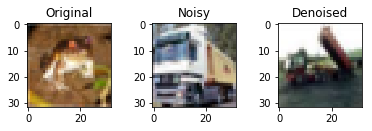

In [11]:
def show_img(orig, noisy, denoised):
    fig=plt.figure()
    
    orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
    denoised = denoised.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    noisy    = (noisy - noisy.min()) / (noisy.max() - noisy.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 2, title='Noisy')
    plt.imshow(noisy)
    
    fig.add_subplot(1, 3, 3, title='Denoised')
    plt.imshow(denoised)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    
# To test
show_img(cifar10_train[0][0].numpy(), cifar10_train[1][0].numpy(), cifar10_train[2][0].numpy())

**Some hyper parameters**

In [5]:
batch_size = 250 # Reduce this if you get out-of-memory error
learning_rate = 0.001
noise_level = 0.1

**Create the dataloader**

In [6]:
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=1)
cifar10_valid_loader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=True, num_workers=1)

**The Denoising Autoencoder**

In [6]:
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 32 x 32 x 3 (input)

        self.conv1e = nn.Conv2d(3, 24, 3, padding=2)        # 30 x 30 x 24
        self.conv2e = nn.Conv2d(24, 48, 3, padding=2)       # 28 x 28 x 48
        self.conv3e = nn.Conv2d(48, 96, 3, padding=2)       # 26 x 26 x 96
        self.conv4e = nn.Conv2d(96, 128, 3, padding=2)      # 24 x 24 x 128
        self.conv5e = nn.Conv2d(128, 256, 3, padding=2)     # 22 x 22 x 256
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)  # 11 x 11 x 256

        self.mp1d = nn.MaxUnpool2d(2)
        self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
        self.conv4d = nn.ConvTranspose2d(128, 96, 3, padding=2)
        self.conv3d = nn.ConvTranspose2d(96, 48, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(24, 3, 3, padding=2)
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)
        x = self.conv4e(x)
        x = F.relu(x)
        x = self.conv5e(x)
        x = F.relu(x)
        x, i = se lf.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv5d(x)
        x = F.relu(x)
        x = self.conv4d(x)
        x = F.relu(x)    
        x = self.conv3d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv1d(x)
        x = F.relu(x)
        
        return x


In [7]:
autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [ ]:
train_loss = []
valid_loss = []

for i in range(10):
    
    # Let's train the model
    
    total_loss = 0.0
    total_iter = 0
    autoencoder.train()
    for image, label in cifar10_train_loader:
        
        noise = torch.randn(image.shape[0], 3, 32, 32) * noise_level
        image_n = torch.add(image, noise)
        
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()

        optimizer.zero_grad()
        output = autoencoder(image_n)
        
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        
        total_iter += 1
        total_loss += loss.data[0]

In [ ]:
    # Let's record the validation loss
    
    total_val_loss = 0.0
    total_val_iter = 0
    autoencoder.eval()
    for image, label in cifar10_valid_loader:
        
        noise = torch.randn(image.shape[0], 3, 32, 32) * noise_level
        image_n = torch.add(image, noise)
        
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        
        output = autoencoder(image_n)
        loss = loss_func(output, image)
        
        total_val_iter += 1
        total_val_loss += loss.data[0]

Iteration  1


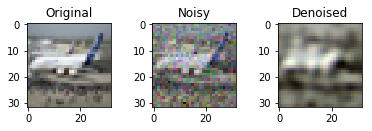

Iteration  2


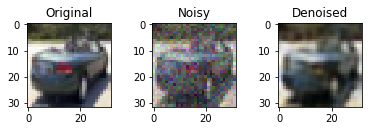

Iteration  3


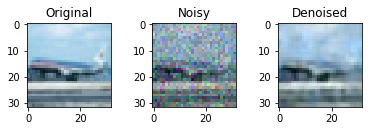

Iteration  4


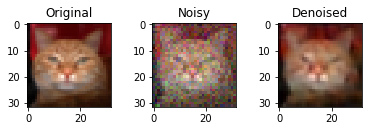

Iteration  5


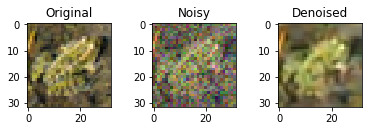

Iteration  6


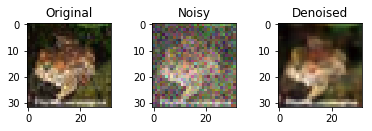

Iteration  7


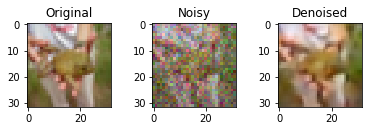

Iteration  8


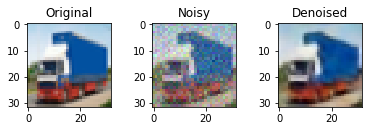

Iteration  9


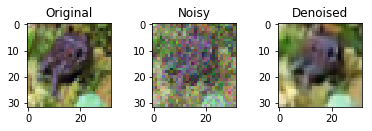

Iteration  10


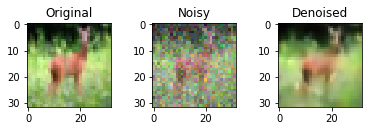

In [8]:
    
    # Let's visualize the first image of the last batch in our validation set
    orig = image[0].cpu()
    noisy = image_n[0].cpu()
    denoised = output[0].cpu()

    orig = orig.data.numpy()
    noisy = noisy.data.numpy()
    denoised = denoised.data.numpy()

    print("Iteration ", i+1)
    show_img(orig, noisy, denoised)
    
    train_loss.append(total_loss / total_iter)
    valid_loss.append(total_val_loss / total_val_iter)
    

In [9]:
# Save the model
torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

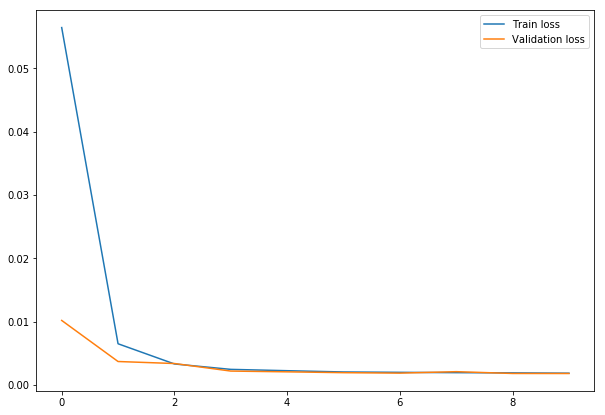

In [10]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

### Let's do standalone inference

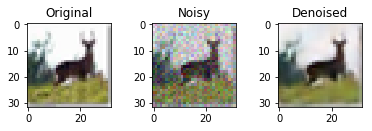

In [67]:
import random

img, _ = random.choice(cifar10_valid)
img    = img.resize_((1, 3, 32, 32))
noise  = torch.randn((1, 3, 32, 32)) * noise_level
img_n  = torch.add(img, noise)

img_n = Variable(img_n).cuda()
denoised = autoencoder(img_n)


show_img(img[0].numpy(), img_n[0].data.cpu().numpy(), denoised[0].data.cpu().numpy())

### DCGAN

In [25]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

## Loading data

In [12]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)


Files already downloaded and verified


In [ ]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# Network Initialization

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator


In [ ]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)

# Discriminator

In [ ]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)

# Defining loss functions


In [ ]:

criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [ ]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# Defining optimiser


In [ ]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# Training 

In [ ]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, 

In [ ]:
############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

In [ ]:
[0/25][0/782] Loss_D: 1.9319 Loss_G: 6.8388 D(x): 0.5714 D(G(z)): 0.6585 / 0.0017
[0/25][1/782] Loss_D: 1.1639 Loss_G: 4.7477 D(x): 0.5312 D(G(z)): 0.2595 / 0.0121
[0/25][2/782] Loss_D: 1.4035 Loss_G: 5.7094 D(x): 0.7775 D(G(z)): 0.6010 / 0.0057
[0/25][3/782] Loss_D: 1.0102 Loss_G: 6.6792 D(x): 0.7644 D(G(z)): 0.4161 / 0.0018
[0/25][4/782] Loss_D: 1.0500 Loss_G: 5.5019 D(x): 0.5927 D(G(z)): 0.2072 / 0.0057
[0/25][5/782] Loss_D: 1.0506 Loss_G: 6.7037 D(x): 0.7679 D(G(z)): 0.3902 / 0.0017
[0/25][6/782] Loss_D: 0.7384 Loss_G: 6.7155 D(x): 0.7384 D(G(z)): 0.2328 / 0.0016
[0/25][7/782] Loss_D: 0.7202 Loss_G: 7.6076 D(x): 0.8122 D(G(z)): 0.2940 / 0.0007
[0/25][8/782] Loss_D: 0.4637 Loss_G: 7.6970 D(x): 0.8271 D(G(z)): 0.1884 / 0.0007
[0/25][9/782] Loss_D: 0.9796 Loss_G: 8.9602 D(x): 0.7412 D(G(z)): 0.3794 / 0.0002
                ***************************************************************
[24/25][771/782] Loss_D: 0.4215 Loss_G: 2.7473 D(x): 0.8058 D(G(z)): 0.1529 / 0.0905
[24/25][772/782] Loss_D: 0.4507 Loss_G: 2.0775 D(x): 0.7647 D(G(z)): 0.1320 / 0.1629
[24/25][773/782] Loss_D: 0.5852 Loss_G: 4.8456 D(x): 0.9277 D(G(z)): 0.3553 / 0.0119
[24/25][774/782] Loss_D: 0.2810 Loss_G: 3.3383 D(x): 0.8093 D(G(z)): 0.0486 / 0.0527
[24/25][775/782] Loss_D: 0.4784 Loss_G: 1.0426 D(x): 0.7094 D(G(z)): 0.0545 / 0.4184
[24/25][776/782] Loss_D: 0.9105 Loss_G: 5.4908 D(x): 0.9763 D(G(z)): 0.5061 / 0.0078
[24/25][777/782] Loss_D: 0.5165 Loss_G: 3.3470 D(x): 0.6506 D(G(z)): 0.0265 / 0.0570
[24/25][778/782] Loss_D: 0.2392 Loss_G: 2.3537 D(x): 0.8652 D(G(z)): 0.0755 / 0.1395
[24/25][779/782] Loss_D: 0.3730 Loss_G: 2.7142 D(x): 0.8883 D(G(z)): 0.2005 / 0.0819
[24/25][780/782] Loss_D: 0.3637 Loss_G: 3.7707 D(x): 0.9005 D(G(z)): 0.2054 / 0.0315
[24/25][781/782] Loss_D: 0.3521 Loss_G: 2.8298 D(x): 0.7519 D(G(z)): 0.0252 / 0.0752              

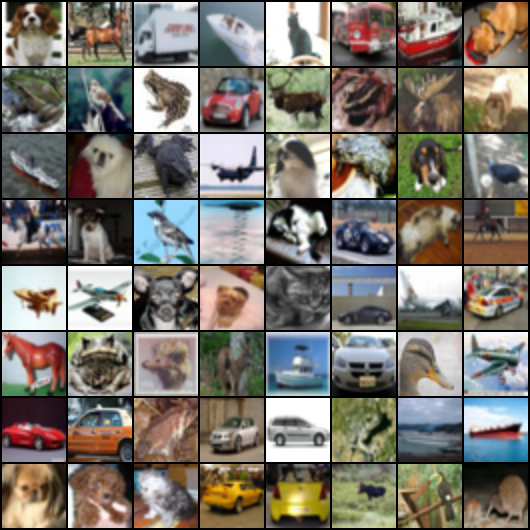

In [26]:
Image.open('real.png')

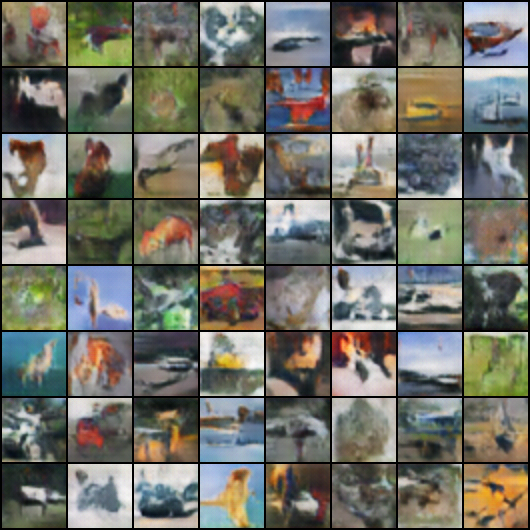

In [28]:
Image.open('fake_epoch24.png')